<a href="https://colab.research.google.com/github/ethanmarshallanalytics/Deep-Learning-and-Neural-Networks/blob/main/MATH_6373_Homework_4_CIFAR_10_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1

In [ ]:

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check for device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the AlexNet architecture with batch normalization
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),  # No dropout
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),  # No dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Prepare CIFAR-10 dataset and dataloaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match AlexNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_data, val_data = torch.utils.data.random_split(train_dataset, [45000, 5000])
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Initialize the model, loss function, and optimizer
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

    # Save the model with the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')

# Plot training and validation loss, and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

# Load the best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch [1/20], Train Loss: 1.4239, Val Loss: 1.2189, Val Accuracy: 0.5688
Epoch [2/20], Train Loss: 1.0131, Val Loss: 1.0184, Val Accuracy: 0.6420
Epoch [3/20], Train Loss: 0.8345, Val Loss: 0.8205, Val Accuracy: 0.7102
Epoch [4/20], Train Loss: 0.7171, Val Loss: 0.7956, Val Accuracy: 0.7198
Epoch [5/20], Train Loss: 0.6357, Val Loss: 0.8140, Val Accuracy: 0.7144
Epoch [6/20], Train Loss: 0.5670, Val Loss: 0.6683, Val Accuracy: 0.7706
Epoch [7/20], Train Loss: 0.5122, Val Loss: 0.6460, Val Accuracy: 0.7870
Epoch [8/20], Train Loss: 0.4698, Val Loss: 0.6193, Val Accuracy: 0.7882
Epoch [9/20], Train Loss: 0.4250, Val Loss: 0.5861, Val Accuracy: 0.8076
Epoch [10/20], Train Loss: 0.3869, Val Loss: 0.6006, Val Accuracy: 0.8008
Epoch [11/20], Train Loss: 0.3525, Val Loss: 0.5427, Val Accuracy: 0.8210
Epoch [12/20], Train Loss: 0.3148, Val Loss: 0.5370, Val Accuracy: 0.8226
Epoch [13/20], Train Loss: 0.2874, Val Loss: 0.5979, Val Accuracy: 0.7984
Epoch [14/20], Train Loss: 0.2677, Val Loss: 0.

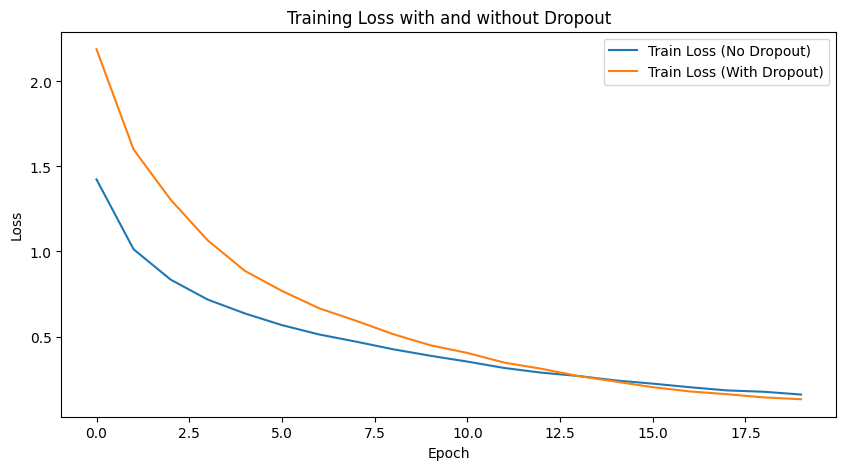

In [4]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move tensors to the same device as the model
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move tensors to the same device as the model
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')

        # Save the model with the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model_dropout.pth')

    return train_losses, val_losses, val_accuracies

# Function to test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move tensors to the same device as the model
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    return test_accuracy

# Without Dropout
model_no_dropout = AlexNet().to(device)
optimizer_no_dropout = torch.optim.SGD(model_no_dropout.parameters(), lr=learning_rate, momentum=0.9)
criterion_no_dropout = nn.CrossEntropyLoss()

train_losses_no_dropout, val_losses_no_dropout, val_accuracies_no_dropout = train_model(model_no_dropout, train_loader, val_loader, criterion_no_dropout, optimizer_no_dropout, num_epochs)
test_accuracy_no_dropout = test_model(model_no_dropout, test_loader)

# With Dropout
model_with_dropout = AlexNetDropout().to(device)
optimizer_with_dropout = torch.optim.SGD(model_with_dropout.parameters(), lr=learning_rate, momentum=0.9)
criterion_with_dropout = nn.CrossEntropyLoss()

train_losses_with_dropout, val_losses_with_dropout, val_accuracies_with_dropout = train_model(model_with_dropout, train_loader, val_loader, criterion_with_dropout, optimizer_with_dropout, num_epochs)
test_accuracy_with_dropout = test_model(model_with_dropout, test_loader)

print(f'Test Accuracy (No Dropout): {test_accuracy_no_dropout:.4f}')
print(f'Test Accuracy (With Dropout): {test_accuracy_with_dropout:.4f}')

# Plot training loss functions
plt.figure(figsize=(10, 5))
plt.plot(train_losses_no_dropout, label='Train Loss (No Dropout)')
plt.plot(train_losses_with_dropout, label='Train Loss (With Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss with and without Dropout')
plt.show()
